CTM evaluation

In [1]:
import pandas as pd
import numpy as np


from contextualized_topic_models.models.ctm import CombinedTM
from contextualized_topic_models.utils.data_preparation import TopicModelDataPreparation
# from contextualized_topic_models.utils.preprocessing import WhiteSpacePreprocessingStopwords

import nltk

import os
from pathlib import Path
import json
from datetime import datetime
import pickle

os.environ["TOKENIZERS_PARALLELISM"] = "false"          # disable huggingface warning

/root/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload

In [3]:
import sys

sys.path.append('../')

In [4]:
# load the dataset
# TODO: load external dataset

%autoreload 2
from dataset_loader import GENRES, load_dataset

genre = GENRES.INDIE
unique_list = ['review_text']

dataset_folder = Path(f'../../dataset/topic_modelling/top_11_genres_unique_[{",".join(unique_list)}]')
dataset, dataset_path = load_dataset(genre, dataset_folder)

# create an untoucher ver of the dataset for retrieving original text
dataset_untouched = dataset.copy()

dataset.info(verbose=True)

Load dataset from: /root/FYP/NLP/dev-workspace/dataset/topic_modelling/top_11_genres_unique_[review_text]/01_indie.pkl





<class 'pandas.core.frame.DataFrame'>
Index: 725737 entries, 25636 to 4179608
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   index         725737 non-null  int64 
 1   app_id        725737 non-null  int64 
 2   app_name      725737 non-null  object
 3   review_text   725737 non-null  object
 4   review_score  725737 non-null  int64 
 5   review_votes  725737 non-null  int64 
 6   genre_id      725737 non-null  object
 7   category_id   725737 non-null  object
dtypes: int64(4), object(4)
memory usage: 49.8+ MB


In [8]:
# data preprocessing
# MUST BE IDENTICAL TO THE ONE USED IN TRAINING

import sys
sys.path.append('../../sa/')

%autoreload 2
import str_cleaning_functions

# copied from lda_demo_gridsearch.ipynb
def cleaning(df, review):
    df[review] = df[review].apply(lambda x: str_cleaning_functions.remove_links(x))
    df[review] = df[review].apply(lambda x: str_cleaning_functions.remove_links2(x))
    df[review] = df[review].apply(lambda x: str_cleaning_functions.clean(x))
    df[review] = df[review].apply(lambda x: str_cleaning_functions.deEmojify(x))
    df[review] = df[review].apply(lambda x: str_cleaning_functions.remove_non_letters(x))
    df[review] = df[review].apply(lambda x: x.lower())
    df[review] = df[review].apply(lambda x: str_cleaning_functions.unify_whitespaces(x))
    df[review] = df[review].apply(lambda x: str_cleaning_functions.remove_stopword(x))
    df[review] = df[review].apply(lambda x: str_cleaning_functions.unify_whitespaces(x))

# def cleaning_strlist(str_list):
#     str_list = list(map(lambda x: clean(x), str_list))
#     str_list = list(map(lambda x: deEmojify(x), str_list))

#     str_list = list(map(lambda x: x.lower(), str_list))
#     str_list = list(map(lambda x: remove_num(x), str_list))
#     str_list = list(map(lambda x: unify_whitespaces(x), str_list))

#     str_list = list(map(lambda x: _deaccent(x), str_list))
#     str_list = list(map(lambda x: remove_non_alphabets(x), str_list))
#     str_list = list(map(lambda x: remove_stopword(x), str_list))
#     return str_list

# copied from bert_demo_gridsearch.ipynb
def cleaning_little(df, review):
    df[review] = df[review].apply(lambda x: str_cleaning_functions.remove_links(x))
    df[review] = df[review].apply(lambda x: str_cleaning_functions.remove_links2(x))
    df[review] = df[review].apply(lambda x: str_cleaning_functions.clean(x))
    df[review] = df[review].apply(lambda x: str_cleaning_functions.deEmojify(x))
    df[review] = df[review].apply(lambda x: str_cleaning_functions.unify_whitespaces(x))

In [9]:
# create a copy of the dataset, as we need both untouched text and cleaned text
dataset['review_text_bow'] = dataset['review_text'].copy()

# also a copy for eval with LLM
# dataset_eval = dataset.copy()

In [10]:
cleaning(dataset, 'review_text_bow')
cleaning_little(dataset, 'review_text')

In [11]:
# skip removing reviews with too many punctuations for real-life performance

In [12]:
# remove docs with 0 len

# remove docs with 0 len

def _filter_zero_len(x):
    if len(x['review_text']) == 0 or len(x['review_text_bow']) == 0:
        return False
    return True

dataset = dataset[dataset.apply(lambda x: _filter_zero_len(x), axis=1)]

In [13]:
print(len(dataset))

723659


Apply lemmatizing to the preprocessed dataset as well (for BoW)

The function is identical in LDA

In [14]:
# do lemmatization, but not stemming (as part of speech is important in topic modelling)
# use nltk wordnet for lemmatization

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

lemma = WordNetLemmatizer()

# from https://stackoverflow.com/questions/25534214/nltk-wordnet-lemmatizer-shouldnt-it-lemmatize-all-inflections-of-a-word

# from: https://www.cnblogs.com/jclian91/p/9898511.html
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None     # if none -> created as noun by wordnet
    
def lemmatization(text):
   # use nltk to get PoS tag
    tagged = nltk.pos_tag(nltk.word_tokenize(text))

    # then we only need adj, adv, verb, noun
    # convert from nltk Penn Treebank tag to wordnet tag
    wn_tagged = list(map(lambda x: (x[0], get_wordnet_pos(x[1])), tagged))

    # lemmatize by the PoS
    lemmatized = list(map(lambda x: lemma.lemmatize(x[0], pos=x[1] if x[1] else wordnet.NOUN), wn_tagged))
    # lemma.lemmatize(wn_tagged[0], pos=wordnet.NOUN)

    return lemmatized

In [15]:
from datasets import Dataset

# X_preprocessed = list(map(lambda x: lemmatization(x), X_preprocessed))
# X_preprocessed = list(map(lambda x: ' '.join(x), X_preprocessed))

def lemmatization_dataset(data):
    return {'review_text2': ' '.join(lemmatization(data['review_text']))}

temp_dataset = Dataset.from_dict({'review_text': dataset['review_text_bow'].values})
temp_dataset = temp_dataset.map(lemmatization_dataset, num_proc=4)      # speed up lemmatization
dataset['review_text_bow'] = temp_dataset['review_text2']

Parameter 'function'=<function lemmatization_dataset at 0x7f1e98bbb3a0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
Map (num_proc=4): 100%|██████████| 723659/723659 [02:50<00:00, 4243.50 examples/s]
/root/miniforge3/envs/fyp-test-wsl-tm/lib/python3.9/site-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/root/miniforge3/envs/fyp-test-wsl-tm/lib/python3.9/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by 

In [ ]:
from copy import deepcopy

X_contextual = dataset['review_text'].values
X_bow = dataset['review_text_bow'].values
X = deepcopy(X_contextual)

In [61]:
# save the dataset for eval

dataset_path = Path(f'category_{str(genre)}_unique_review_text')
dataset_path = dataset_path.joinpath(
    Path(f'preprocessed_data/{genre.value:02}_{str(genre)}_dataset_eval.pkl')
)

if not dataset_path.exists():
    dataset.to_pickle(dataset_path)
else:
    print(f'File {dataset_path} already exists')
    print('Skip saving')

Create split text for models trained with split tokens (Optional)

In [16]:
import torch
import platform
if platform.system() == 'Linux' or platform.system() == 'Windows':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
else:
    device = torch.device('mps')        # m-series mac machine

print(device)

cuda


In [53]:
# copy from ctm_training.ipynb

# from datasets import Dataset
from tqdm.autonotebook import trange

def split_X_contextual_X_bow(X_contextual, X_bow, X, sbert, split:bool=False):
    if not split:
        return X_contextual, X_bow, X, list(range(len(X_contextual)))
    else:
        X_contextual_new, X_bow_new, X_new = [], [], []
        tokenizer = sbert[0].tokenizer

        # for eval
        _original_iloc = []

        batch_size = 64
        for start_index in trange(0, len(X_contextual), batch_size, desc="Batches", disable=False):
            sentence_batch = X_contextual[start_index:start_index+batch_size]
            features = tokenizer(sentence_batch, return_attention_mask=True, return_token_type_ids=True, add_special_tokens=False, return_tensors=None, truncation=False)

            # split overlapping
            features_split = split_tokens_into_smaller_chunks(features, sbert.max_seq_length-2,  sbert.max_seq_length-2, 1)

            for i, input_id_list in enumerate(features_split['input_ids']):
                for input_id in input_id_list:
                    X_contextual_new.append(tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_id)))
                    X_bow_new.append(X_bow[start_index+i])
                    X_new.append(X[start_index+i])

                # for eval
                _original_iloc.extend([start_index+i]*len(input_id_list))


        assert len(X_contextual_new) == len(X_bow_new), "X_contextual_new and X_bow_new should have the same length. Found: {} and {}".format(len(X_contextual_new), len(X_bow_new))
        assert len(X_contextual_new) == len(X_new), "X_contextual_new and X_new should have the same length. Found: {} and {}".format(len(X_contextual_new), len(X_new))
        assert len(X_contextual_new) == len(_original_iloc), "X_contextual_new and _original_iloc should have the same length. Found: {} and {}".format(len(X_contextual_new), len(_original_iloc))
        return X_contextual_new, X_bow_new, X_new, _original_iloc
   
# ####################
# # helper functions
# ####################
    
# tokens spliting helper functions

def split_tokens_into_smaller_chunks(
    data,
    chunk_size: int,
    stride: int,
    minimal_chunk_length: int,
) -> dict:
    """Splits tokens into overlapping chunks with given size and stride."""

    _new_input_id_chunks = []
    _new_token_type_ids = []
    _new_mask_chunks = []

    for input_id, token_type_id, mask_chunk in zip(data['input_ids'], data['token_type_ids'], data['attention_mask']):
        _input_id_chunk = split_overlapping(input_id, chunk_size, stride, minimal_chunk_length)
        _token_type_id = split_overlapping(token_type_id, chunk_size, stride, minimal_chunk_length)
        _mask_chunk = split_overlapping(mask_chunk, chunk_size, stride, minimal_chunk_length)

        _new_input_id_chunks.append(_input_id_chunk)
        _new_token_type_ids.append(_token_type_id)
        _new_mask_chunks.append(_mask_chunk)    

    return {'input_ids':_new_input_id_chunks, 'token_type_ids':_new_token_type_ids, 'attention_mask': _new_mask_chunks}

def split_overlapping(tensor:list[int], chunk_size: int, stride: int, minimal_chunk_length: int) -> list[list[int]]:
    """Helper function for dividing 1-dimensional tensors into overlapping chunks."""
    # check_split_parameters_consistency(chunk_size, stride, minimal_chunk_length)
    result = [tensor[i : i + chunk_size] for i in range(0, len(tensor), stride)]
    if len(result) > 1:
        # ignore chunks with less than minimal_length number of tokens
        result = [x for x in result if len(x) >= minimal_chunk_length]
    return result


def tokenize_dataset(data, tokenizer):
    # return sbert_model[0].tokenizer(data['text'], return_attention_mask=True, return_token_type_ids=True, add_special_tokens=False, return_tensors=None, truncation=False)
    return {'tokenized': tokenizer(data['text'], return_attention_mask=True, return_token_type_ids=True, add_special_tokens=False, return_tensors=None, truncation=False)}


In [18]:
# ATTENTION !!!!!
# define the sbert model (SHOULD BE THE SAME AS TRAINING)
# also define whether we want to split the tokens or not

split_sentences = True
sbert_model_name = 'all-MiniLM-L6-v2'

# load the sbert model
from sentence_transformers import SentenceTransformer
sbert = SentenceTransformer(sbert_model_name, device=device)

In [54]:
X = list(dataset['review_text'].values)
X_preprocessed = list(dataset['review_text_bow'].values)

X_contextual, X_bow, X, _original_iloc = split_X_contextual_X_bow(
    X, X_preprocessed, X, 
    sbert, 
    split=split_sentences)

Batches: 100%|██████████| 11308/11308 [01:58<00:00, 95.14it/s] 


In [55]:
_original_iloc

[0,
 0,
 1,
 2,
 2,
 3,
 4,
 4,
 4,
 4,
 5,
 5,
 6,
 7,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 22,
 23,
 24,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 104,
 105,
 106,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,

In [23]:
print(len(X_contextual), len(X_bow), len(X))

789451 789451 789451


In [58]:
# save the preprocessed data

dataset_eval_split = dataset.iloc[_original_iloc]
dataset_eval_split['review_text_split'] = X_contextual

dataset_eval_split['review_text_untouched'] = dataset_untouched.loc[dataset_eval_split.index]['review_text'].values

dataset_eval_split

/tmp/ipykernel_8958/3141554812.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_eval_split['review_text_split'] = X_contextual
/tmp/ipykernel_8958/3141554812.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_eval_split['review_text_untouched'] = dataset_untouched.loc[dataset_eval_split.index]['review_text'].values


,index,app_id,app_name,review_text,review_score,review_votes,genre_id,category_id,review_text_bow,review_text_split,review_text_untouched
25636,32133,102200,Runespell: Overture,Take one part Faerie Solitaire and two parts P...,1,0,"[25, 23, 3]","[2, 22, 23, 15, 25]",take one part faerie solitaire two part puzzle...,take one part faerie solitaire and two parts p...,Take one part Faerie Solitaire and two parts P...
25636,32133,102200,Runespell: Overture,Take one part Faerie Solitaire and two parts P...,1,0,"[25, 23, 3]","[2, 22, 23, 15, 25]",take one part faerie solitaire two part puzzle...,it ' s an entertaining casual game to play. it...,Take one part Faerie Solitaire and two parts P...
25637,32134,102200,Runespell: Overture,Why don't they make more games like this?! Sim...,1,0,"[25, 23, 3]","[2, 22, 23, 15, 25]",make game like simple card play mechanic fun a...,why don ' t they make more games like this?! s...,Why don't they make more games like this?! Si...
25638,32135,102200,Runespell: Overture,Runespell: Overture melds together classic RPG...,1,0,"[25, 23, 3]","[2, 22, 23, 15, 25]",runespell overture meld together classic rpg c...,runespell : overture melds together classic rp...,Runespell: Overture melds together classic RPG...
25638,32135,102200,Runespell: Overture,Runespell: Overture melds together classic RPG...,1,0,"[25, 23, 3]","[2, 22, 23, 15, 25]",runespell overture meld together classic rpg c...,"##itaire, poker game - and it is done very wel...",Runespell: Overture melds together classic RPG...
...,...,...,...,...,...,...,...,...,...,...,...
4179604,6416380,99900,Spiral Knights,I hadn't played Spiral Knights for over 2 year...,1,1,"[1, 25, 4, 37, 23, 29, 3]","[2, 1, 20, 9, 22, 29, 35, 18]",played spiral knight year decide give another ...,i hadn ' t played spiral knights for over 2 ye...,I hadn't played Spiral Knights for over 2 year...
4179604,6416380,99900,Spiral Knights,I hadn't played Spiral Knights for over 2 year...,1,1,"[1, 25, 4, 37, 23, 29, 3]","[2, 1, 20, 9, 22, 29, 35, 18]",played spiral knight year decide give another ...,you go out of your way to organise something w...,I hadn't played Spiral Knights for over 2 year...
4179605,6416381,99900,Spiral Knights,This game use to be they did the rework on ene...,0,0,"[1, 25, 4, 37, 23, 29, 3]","[2, 1, 20, 9, 22, 29, 35, 18]",game use rework energy heat level long time ag...,this game use to be they did the rework on ene...,This game use to be good..until they did the r...
4179607,6416383,99900,Spiral Knights,This game is good to play by your self or with...,1,1,"[1, 25, 4, 37, 23, 29, 3]","[2, 1, 20, 9, 22, 29, 35, 18]",game good play self friends get annoy farm new...,this game is good to play by your self or with...,This game is good to play by your self or with...


In [6]:
# save the eval dataset for reloading

dataset_path = Path('category_indie_unique_review_text')
dataset_path = dataset_path.joinpath(
    Path(f'preprocessed_data/{genre.value:02}_{str(genre)}_dataset_eval_[split].pkl')
)

if not dataset_path.parent.exists():
    dataset_path.parent.mkdir(parents=True)

if not dataset_path.exists():
    dataset_eval_split.to_pickle(dataset_path)

    print('Save to', dataset_path)

---

In [7]:
# load the preprocessed data

split_sentence = True

dataset_preprocessed_path = Path(f'category_{str(genre)}_unique_review_text')
dataset_preprocessed_path = dataset_preprocessed_path.joinpath(
    Path(f'preprocessed_data/{genre.value:02}_{str(genre)}_dataset_eval{"_[split]" if split_sentence else ""}.pkl')
)

print(dataset_preprocessed_path)

if dataset_preprocessed_path.exists():
    dataset = pd.read_pickle(dataset_preprocessed_path)
    print(len(dataset))
    print('\n\n')
    print(dataset.info(verbose=True))

    if split_sentence:
        X_contextual, X_bow, X  = list(dataset['review_text_split'].values), list(dataset['review_text_bow'].values), list(dataset['review_text'].values)
    else:
        X_contextual, X_bow, X  = list(dataset['review_text'].values), list(dataset['review_text_bow'].values), list(dataset['review_text'].values)
        
else:
    print(f"{dataset_preprocessed_path} does not exist")

category_indie_unique_review_text/preprocessed_data/01_indie_dataset_eval_[split].pkl
789451



<class 'pandas.core.frame.DataFrame'>
Index: 789451 entries, 25636 to 4179608
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   index                  789451 non-null  int64 
 1   app_id                 789451 non-null  int64 
 2   app_name               789451 non-null  object
 3   review_text            789451 non-null  object
 4   review_score           789451 non-null  int64 
 5   review_votes           789451 non-null  int64 
 6   genre_id               789451 non-null  object
 7   category_id            789451 non-null  object
 8   review_text_bow        789451 non-null  object
 9   review_text_split      789451 non-null  object
 10  review_text_untouched  789451 non-null  object
dtypes: int64(4), object(7)
memory usage: 72.3+ MB
None


---

Load the training result

In [8]:
sys.path.append('../')

from eval_metrics import compute_inverted_rbo, compute_topic_diversity, compute_pairwise_jaccard_similarity, \
                        METRICS, SEARCH_BEHAVIOUR, COHERENCE_MODEL_METRICS

In [9]:
%autoreload 2
from ctm_dataset_creation import create_ctm_dataset
from ctm_utils import _load_ctm_model, _get_topics, _get_topic_document_metrix, _get_topic_word_metrix

In [10]:
import torch
import platform
if platform.system() == 'Linux' or platform.system() == 'Windows':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
else:
    device = torch.device('mps')        # m-series mac machine

print(device)

cuda


In [11]:
# copy from ctm_training.ipynb

from tqdm.autonotebook import trange

def split_X_contextual_X_bow(X_contextual, X_bow, X, sbert, split:bool=False):
    if not split:
        return X_contextual, X_bow, X
    else:
        X_contextual_new, X_bow_new, X_new = [], [], []
        tokenizer = sbert[0].tokenizer

        batch_size = 64
        for start_index in trange(0, len(X_contextual), batch_size, desc="Batches", disable=False):
            sentence_batch = X_contextual[start_index:start_index+batch_size]
            features = tokenizer(sentence_batch, return_attention_mask=True, return_token_type_ids=True, add_special_tokens=False, return_tensors=None, truncation=False)

            # split overlapping
            features_split = split_tokens_into_smaller_chunks(features, sbert.max_seq_length-2,  sbert.max_seq_length-2, 1)

            for i, input_id_list in enumerate(features_split['input_ids']):
                for input_id in input_id_list:
                    X_contextual_new.append(tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_id)))
                    X_bow_new.append(X_bow[start_index+i])
                    X_new.append(X[start_index+i])


        assert len(X_contextual_new) == len(X_bow_new), "X_contextual_new and X_bow_new should have the same length. Found: {} and {}".format(len(X_contextual_new), len(X_bow_new))
        assert len(X_contextual_new) == len(X_new), "X_contextual_new and X_new should have the same length. Found: {} and {}".format(len(X_contextual_new), len(X_new))
        return X_contextual_new, X_bow_new, X_new
    
# ####################
# # helper functions
# ####################
    
# tokens spliting helper functions

def split_tokens_into_smaller_chunks(
    data,
    chunk_size: int,
    stride: int,
    minimal_chunk_length: int,
) -> dict:
    """Splits tokens into overlapping chunks with given size and stride."""

    _new_input_id_chunks = []
    _new_token_type_ids = []
    _new_mask_chunks = []

    for input_id, token_type_id, mask_chunk in zip(data['input_ids'], data['token_type_ids'], data['attention_mask']):
        _input_id_chunk = split_overlapping(input_id, chunk_size, stride, minimal_chunk_length)
        _token_type_id = split_overlapping(token_type_id, chunk_size, stride, minimal_chunk_length)
        _mask_chunk = split_overlapping(mask_chunk, chunk_size, stride, minimal_chunk_length)

        _new_input_id_chunks.append(_input_id_chunk)
        _new_token_type_ids.append(_token_type_id)
        _new_mask_chunks.append(_mask_chunk)    

    return {'input_ids':_new_input_id_chunks, 'token_type_ids':_new_token_type_ids, 'attention_mask': _new_mask_chunks}

def split_overlapping(tensor:list[int], chunk_size: int, stride: int, minimal_chunk_length: int) -> list[list[int]]:
    """Helper function for dividing 1-dimensional tensors into overlapping chunks."""
    # check_split_parameters_consistency(chunk_size, stride, minimal_chunk_length)
    result = [tensor[i : i + chunk_size] for i in range(0, len(tensor), stride)]
    if len(result) > 1:
        # ignore chunks with less than minimal_length number of tokens
        result = [x for x in result if len(x) >= minimal_chunk_length]
    return result


def tokenize_dataset(data, tokenizer):
    # return sbert_model[0].tokenizer(data['text'], return_attention_mask=True, return_token_type_ids=True, add_special_tokens=False, return_tensors=None, truncation=False)
    return {'tokenized': tokenizer(data['text'], return_attention_mask=True, return_token_type_ids=True, add_special_tokens=False, return_tensors=None, truncation=False)}


In [12]:
# load the model from disk to compare the results

search_behaviour = SEARCH_BEHAVIOUR.GRID_SEARCH
split_sentences = True
sbert_model_name = 'all-MiniLM-L6-v2'


training_datetime = datetime(2024, 2, 14, 22, 4, 32)
training_folder_p = Path(f'category_{str(genre)}_unique_review_text')
training_folder = Path(f'ctm{"[split]" if split_sentences else ""}_genre_{str(genre)}_{search_behaviour.value}_{training_datetime.strftime("%Y%m%d_%H%M%S")}')
training_folder = training_folder_p.joinpath(training_folder)

training_result_json_path = training_folder.joinpath('result.json')
with open(training_result_json_path, 'r') as f:
    training_result = json.load(f)


# load the embeddings
model_name_or_path = training_result['best_hyperparameters']['sbert_params']['model_name_or_path']
embeddings_path = training_folder.joinpath(f'embeddings_{model_name_or_path}.pkl')
with open(embeddings_path, 'rb') as f:
    embeddings = np.load(f)

best_model_path = training_result['best_model_checkpoint']
ctm_hyperparameters = training_result['best_hyperparameters']['ctm_params']
sbert_params = training_result['best_hyperparameters']['sbert_params']

# ctm_hyperparameters['bow_size'] = 2000
# ctm_hyperparameters['contextual_size'] = 768

# create the dataset on the fly
with open(Path(best_model_path).joinpath('count_vectorizer.pkl'), 'rb') as f:
    vectorizer = pickle.load(f)

training_dataset, _, _, _, _ = create_ctm_dataset(
    X_contextual, X_bow, X,
    sbert_params, training_folder,
    vectorizer=vectorizer)

/root/miniforge3/envs/fyp-test-wsl-tm/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['00', '000', '00000000000000001', '000001', '001', '00111', '002', '003', '004', '005', '006', '007', '008', '009', '01', '010', '0101', '011', '012', '013', '014', '015', '016', '017', '018', '019', '01d', '01fb', '02', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '02a', '02b', '03', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '03m', '04', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049', '05', '050', '051', '053', '054', '055', '056', '057', '058', '059', '06', '060', '062', '063', '064', '065', '066', '067', '068', '069', '07', '071', '072', '073', '074', '075', '076', '077', '078', '079', '08', '080', '081', '082', '083', '084', '085', '086', '087', '088', '09', '090', '091', '092', '093', '0

Shape of existing embeddings does not match the length of text_for_contextual. Recreating the embeddings.
embeddings.shape[0]: 767674, len(text_for_contextual): 772925


Batches: 100%|██████████| 12077/12077 [03:53<00:00, 51.79it/s] 


In [13]:
# change the best model path

best_model_path = Path(training_result['best_model_checkpoint']).parent.joinpath(
    'ctm_ctm_n_components_40'
)

In [14]:
print(Path(best_model_path))

category_indie_unique_review_text/ctm[split]_genre_indie_grid_search_20240214_220432/ctm_ctm_n_components_40


In [15]:
best_model = _load_ctm_model(Path(best_model_path), ctm_hyperparameters)

/root/miniforge3/envs/fyp-test-wsl-tm/lib/python3.9/site-packages/contextualized_topic_models/models/ctm.py:669: Warning: This is an experimental feature that we has not been fully tested. Refer to the following issue:https://github.com/MilaNLProc/contextualized-topic-models/issues/38
  warnings.warn(


In [ ]:
# whether the model is trained with sentence-split or not

---

Visualization

with the same set of training dataset, we can visualize its topic modeling performance

Create a pyLDAVis alike graph

In [16]:
import pyLDAvis as vis

vocab = vectorizer.get_feature_names_out()

lda_vis_data = best_model.get_ldavis_data_format(vocab, training_dataset, n_samples=10)

ctm_pd = vis.prepare(**lda_vis_data)
vis.display(ctm_pd)

100%|██████████| 12077/12077 [00:20<00:00, 598.57it/s]


Create wordcloud

/root/miniforge3/envs/fyp-test-wsl-tm/lib/python3.9/site-packages/wordcloud/wordcloud.py:522: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/root/miniforge3/envs/fyp-test-wsl-tm/lib/python3.9/site-packages/wordcloud/wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/root/miniforge3/envs/fyp-test-wsl-tm/lib/python3.9/site-packages/wordcloud/wordcloud.py:523: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  Image.ROTATE_90)
/root/miniforge3/envs/fyp-test-wsl-tm/lib/python3.9/site-packages/wordcloud/wordcloud.py:522: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = 

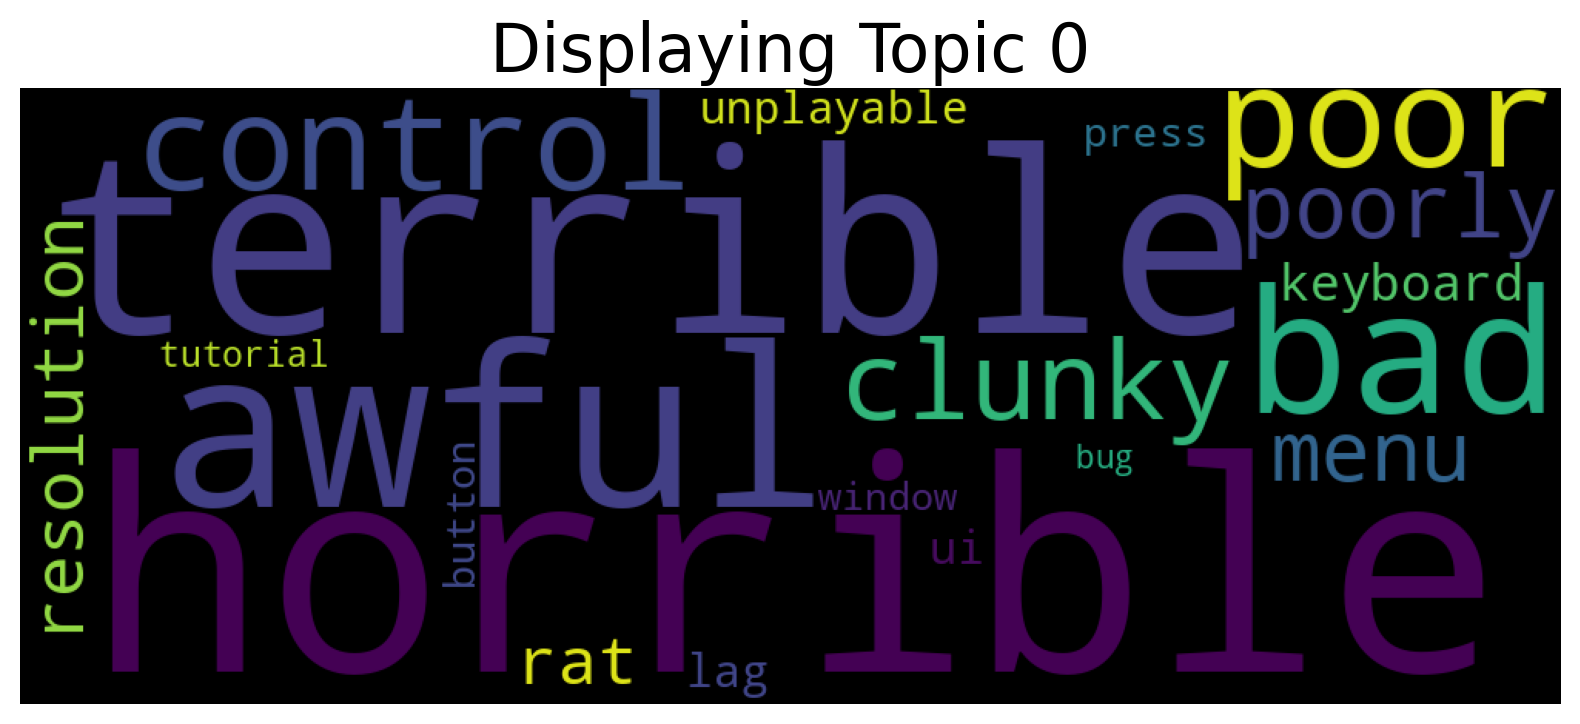

In [29]:
best_model.get_wordcloud(topic_id=0, n_words=20)

---

Get top N keywords for each topic

In [17]:
# get top N keywords for each topic

topic_list = best_model.get_topic_lists(10)

topic_list

top_N_words = 10

for topic_id, _keywords in enumerate(best_model.get_topic_lists(top_N_words)):
    print(f'Topic {topic_id}:')
    print(', '.join(_keywords))
    print()

Topic 0:
horrible, terrible, awful, bad, poor, control, clunky, poorly, menu, resolution

Topic 1:
clone, epic, minecraft, creative, building, mob, alot, mining, terrarium, ton

Topic 2:
shark, diver, dinosaur, bot, rifle, fun, play, team, player, match

Topic 3:
earlier, naturally, lastly, thief, ring, typically, phase, annoyance, helpful, starter

Topic 4:
shelter, scavenge, supply, food, war, sea, civilian, depression, wound, group

Topic 5:
really, like, pretty, thing, fun, good, bos, bad, say, kill

Topic 6:
addict, addictive, awesome, totally, playing, favorite, paced, amazing, pace, absolutely

Topic 7:
pass, lastly, naturally, typically, ring, earlier, crate, thief, indicate, talent

Topic 8:
defense, defence, rts, multiplayer, base, campaign, defender, class, strategic, tactic

Topic 9:
fnaf, animatronics, scare, scary, scar, freddy, jumpscares, horror, office, mask

Topic 10:
fun, friend, friends, addict, ton, alot, extremely, local, op, amazingly

Topic 11:
play, review, for

Get most representative docs

In [18]:
# note that due to its stochastic (sampling) nature, the doc-topic distribution may not be the same each time.
# although a n_samples param is applied
doc_topic_distribution = best_model.get_doc_topic_distribution(training_dataset, n_samples=20)

# sample call
top_docs = best_model.get_top_documents_per_topic_id(X, doc_topic_distribution, 8, k=10)

# repr_docs = {}
# repr_docs_ids = {}

# for topic_id in range(best_model.n_components):
#     repr_docs[topic_id] = best_model.get_top_documents_per_topic_id(X, doc_topic_distribution, topic_id, k=10)
#     repr_docs_ids[topic_id] = list(_get_top_docs_index_per_topic(X, doc_topic_distribution, topic_id, 10))

  0%|          | 0/12077 [00:00<?, ?it/s]

100%|██████████| 12077/12077 [00:21<00:00, 555.16it/s]


In [ ]:
repr_docs = {}
repr_docs_ids = {}

# to get the index of the top documents
def _get_top_docs_index_per_topic(X, doc_topic_distributions, topic_id, k=10):
    probability_list = doc_topic_distributions.T[topic_id]
    ind = probability_list.argsort()[-k:][::-1]
    return ind

for topic_id in range(best_model.n_components):
    repr_docs[topic_id] = best_model.get_top_documents_per_topic_id(X, doc_topic_distribution, topic_id, k=10)
    repr_docs_ids[topic_id] = list(_get_top_docs_index_per_topic(X, doc_topic_distribution, topic_id, 10))

In [19]:
repr_docs

{0: [("You might be wondering if Hexcells Plus is worth getting if you've played the original Hexcells and found it a bit short - it is. It took me about 6x as long, in fact. The original almost feels like a demo compared to this one; it doesn't reach the full potential of Hexcells, in my opinion. So, you're really doing yourself and the game a disservice by not getting Plus.",
   0.9989545),
  ('Fresh and relaxing puzzle game like no other, with clean ui', 0.9988515),
  ('One of the most pointless games I ever played.', 0.9958439),
  ("This is a super fun time waster. If you like cookie clicker-esque games, you'll like this.",
   0.93491477),
  ('Super addictive, and the heart and soul of the game: the music, is amazing. I agree that it is the worlds greatest capitalism simulator. DOWNLOAD IT NOW! THE WORLD IS WAITING TO BE BOUGHT!',
   0.93276757),
  ('i gained 1 trillion dollars while in the bathroom 10/10 would poop again',
   0.92751753),
  ("Won't let me play. When I click play s

In [20]:
repr_docs_ids

{0: [270413,
  270412,
  621253,
  624411,
  623698,
  620534,
  620531,
  620533,
  620537,
  620535],
 1: [30716, 89527, 44464, 30830, 75040, 20224, 38171, 73028, 61288, 34123],
 2: [278295,
  278296,
  278294,
  278293,
  278479,
  278477,
  278292,
  278478,
  278297,
  278480],
 3: [349387,
  258065,
  50854,
  401773,
  697861,
  287398,
  617091,
  732978,
  323031,
  558466],
 4: [305709,
  305713,
  305710,
  305015,
  305712,
  305711,
  305016,
  305020,
  305018,
  305017],
 5: [371087,
  371085,
  371084,
  371086,
  371457,
  371083,
  371456,
  300577,
  371455,
  371576],
 6: [178611,
  498211,
  138160,
  496355,
  259914,
  316567,
  98999,
  77225,
  131142,
  647236],
 7: [188303,
  190899,
  187093,
  194107,
  192219,
  186508,
  188234,
  188169,
  188343,
  187893],
 8: [735693,
  191026,
  738963,
  432416,
  583822,
  583820,
  267556,
  736250,
  583821,
  583823],
 9: [725324,
  725323,
  481566,
  481567,
  481568,
  480397,
  480399,
  481269,
  640119,
  

In [21]:
# create a dataframe with only these repr docs, their topic id, and the probability
df_original_texts = []

for topic_id, _repr_docs_ids in repr_docs_ids.items():
    t = dataset.iloc[_repr_docs_ids]
    t['topic_id'] = topic_id

    df_original_texts.append(t)

df_original_texts = pd.concat(df_original_texts)
df_original_texts

/tmp/ipykernel_28248/3344078714.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t['topic_id'] = topic_id
/tmp/ipykernel_28248/3344078714.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t['topic_id'] = topic_id
/tmp/ipykernel_28248/3344078714.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

,index,app_id,app_name,review_text,review_score,review_votes,genre_id,category_id,review_text_bow,review_text_split,review_text_untouched,topic_id
2131431,3303382,271900,Hexcells Plus,You might be wondering if Hexcells Plus is wor...,1,0,"[4, 23, 2]","[2, 22, 23]",might wonder hexcells plus worth get played or...,you might be wondering if hexcells plus is wor...,You might be wondering if Hexcells Plus is wor...,0
2131430,3303381,271900,Hexcells Plus,"Fresh and relaxing puzzle game like no other, ...",1,0,"[4, 23, 2]","[2, 22, 23]",fresh relax puzzle game like clean ui,"fresh and relaxing puzzle game like no other, ...","Fresh and relaxing puzzle game like no other, ...",0
2903311,4525628,346900,AdVenture Capitalist,One of the most pointless games I ever played.,0,0,"[4, 37, 23]","[2, 22, 29, 23]",one pointless game ever play,one of the most pointless games i ever played.,One of the most pointless games I ever played.,0
2906517,4529136,346900,AdVenture Capitalist,This is a super fun time waster. If you like c...,1,0,"[4, 37, 23]","[2, 22, 29, 23]",super fun time waster like cookie clicker esqu...,this is a super fun time waster. if you like c...,This is a super fun time waster. If you like c...,0
2905818,4528404,346900,AdVenture Capitalist,"Super addictive, and the heart and soul of the...",1,0,"[4, 37, 23]","[2, 22, 29, 23]",super addictive heart soul game music amaze ag...,"super addictive, and the heart and soul of the...","Super addictive, and the heart and soul of the...",0
...,...,...,...,...,...,...,...,...,...,...,...,...
2038387,3157333,266170,Windforge,Don't ever try it. Just don't. There are sky i...,0,1,"[1, 23, 3]","[2, 22]",ever try sky fly ship real huge awesome skywha...,"even if graphics is nothing for you, it ' s re...",Don't ever try it. Just don't. There are sky ...,39
2918400,4543872,348620,Voices from the Sea,So looking at the time I spent on this game pr...,1,0,"[25, 4, 37, 23]",[2],look time spend game probably indicate probabl...,t want to do a whole lot of strategy or anythi...,So looking at the time I spent on this game pr...,39
131168,149561,105600,Terraria,Terraria may not be the best game I have ever ...,1,0,"[1, 25, 23, 3]","[2, 1, 49, 36, 9, 38, 22, 28, 29, 23, 41, 42, 43]",terrarium may best game ever play certainly fa...,combine into a perfect storm of inevitable dea...,Terraria may not be the best game I have ever ...,39
2866025,4448139,342180,Arizona Sunshine,The best VR game out right now.,1,1,"[1, 25, 23]","[2, 1, 49, 36, 9, 38, 22, 52, 54, 29, 31, 40, ...",best vr game right,the best vr game out right now.,The best VR game out right now.,39


In [23]:
# check which repr docs do not begin from beginning of the original review_text

def check_beginning_of_review_text(row):
    t = row['review_text_split'].split()[0].lower()
    return t != row['review_text'][:len(t)].lower()

t = df_original_texts[
    df_original_texts.apply(
        lambda x: check_beginning_of_review_text(x),
        axis=1
    )]

print(len(t))

46


In [24]:
t

,index,app_id,app_name,review_text,review_score,review_votes,genre_id,category_id,review_text_bow,review_text_split,review_text_untouched,topic_id
85814,99894,105600,Terraria,This game IS and always WILL be the BEST game ...,1,0,"[1, 25, 23, 3]","[2, 1, 49, 36, 9, 38, 22, 28, 29, 23, 41, 42, 43]",game always best game history,!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...,This game IS and always WILL be the BEST game ...,1
2156806,3337733,274270,NOT A HERO,YES IT's A REAL PLACE! [ Fun: 8 | Plot: 8 | C...,1,0,"[1, 25, 23]","[2, 22, 29, 18]",yes real place fun plot ctrl gfx sfx stable ye...,yes it ' s a real place! [ fun : 8 | plot : 8 ...,Wales... YES IT's A REAL PLACE! [ Fun: 8 | Pl...,2
92091,106598,105600,Terraria,Ask anyone who's been around me for three minu...,1,0,"[1, 25, 23, 3]","[2, 1, 49, 36, 9, 38, 22, 28, 29, 23, 41, 42, 43]",ask anyone around three minute tell terrarium ...,##ious for you. every ore you mine has a corre...,Ask anyone who's been around me for three minu...,3
2166216,3350306,274940,Depth,TL;DR - 9/10. Pros: -Completely different than...,1,0,"[1, 23]","[2, 1, 49, 36, 22, 28, 29, 13, 30, 35, 23, 8, ...",tl dr pro completely different game come past ...,won ' t play as a human in a game ). the diver...,TL;DR - 9/10. Pros: -Completely different th...,3
2213196,3413314,281370,Real Horror Stories Ultimate Edition,I bought this game not expecting it would be a...,0,1,[23],[2],bought game expect would good get cheap sale m...,and cards. 1 / 10 unacceptable.,I bought this game not expecting it would be a...,4
2406173,3708926,296070,MIND Path to Thalamus E.Edition,Before I get to criticize this game let's firs...,1,0,"[25, 23, 2]","[2, 22, 28, 52, 53, 29, 31, 23]",get criticize game let first talk get whatever...,. even though i think it was on purpose it is ...,Before I get to criticize this game let's firs...,5
2406173,3708926,296070,MIND Path to Thalamus E.Edition,Before I get to criticize this game let's firs...,1,0,"[25, 23, 2]","[2, 22, 28, 52, 53, 29, 31, 23]",get criticize game let first talk get whatever...,"together in the middle, or it woud not have be...",Before I get to criticize this game let's firs...,5
2406173,3708926,296070,MIND Path to Thalamus E.Edition,Before I get to criticize this game let's firs...,1,0,"[25, 23, 2]","[2, 22, 28, 52, 53, 29, 31, 23]",get criticize game let first talk get whatever...,"day and night. i say there are only 4, which a...",Before I get to criticize this game let's firs...,5
2406173,3708926,296070,MIND Path to Thalamus E.Edition,Before I get to criticize this game let's firs...,1,0,"[25, 23, 2]","[2, 22, 28, 52, 53, 29, 31, 23]",get criticize game let first talk get whatever...,"actually. you can hear, that he puts his heart...",Before I get to criticize this game let's firs...,5
2232387,3437388,282070,This War of Mine,I cant help but feel that most of the reviews/...,0,0,"[25, 23, 28]","[2, 22, 29, 30, 18, 23]",cant help feel reviews recommendation game tim...,"by your mistakes. it is, when all is said and ...",I cant help but feel that most of the reviews/...,6


In [25]:
# print out the original text and the split (if any) for reference

for topic_id in repr_docs_ids.keys():
    print(f'Topic {topic_id}:')

    for index, row in df_original_texts[df_original_texts['topic_id'] == topic_id].iterrows():
        print(f'Doc {index}')
        print(f'Original: {row["review_text"]}')
        if split_sentence:
            print(f'Split: {row["review_text_split"]}')
        print()

Topic 0:
Doc 2131431
Original: You might be wondering if Hexcells Plus is worth getting if you've played the original Hexcells and found it a bit short - it is. It took me about 6x as long, in fact. The original almost feels like a demo compared to this one; it doesn't reach the full potential of Hexcells, in my opinion. So, you're really doing yourself and the game a disservice by not getting Plus.
Split: you might be wondering if hexcells plus is worth getting if you ' ve played the original hexcells and found it a bit short - it is. it took me about 6x as long, in fact. the original almost feels like a demo compared to this one ; it doesn ' t reach the full potential of hexcells, in my opinion. so, you ' re really doing yourself and the game a disservice by not getting plus.

Doc 2131430
Original: Fresh and relaxing puzzle game like no other, with clean ui
Split: fresh and relaxing puzzle game like no other, with clean ui

Doc 2903311
Original: One of the most pointless games I ever

---

In [26]:
# within the topic lists (the words)
# find out common words between topics

from itertools import combinations

topic_list = best_model.get_topic_lists(k=10)

common_words = set()
for topic1, topic2 in combinations(topic_list, 2):
    common_words.update(set(topic1).intersection(set(topic2)))

common_words = list(common_words)
common_words.sort()
common_words

['addict',
 'alot',
 'awesome',
 'bad',
 'beautiful',
 'bind',
 'boy',
 'buck',
 'buy',
 'category',
 'challenge',
 'character',
 'depression',
 'differently',
 'dinosaur',
 'dollar',
 'earlier',
 'fantastic',
 'friend',
 'friends',
 'fun',
 'graphic',
 'hint',
 'horror',
 'hour',
 'isaac',
 'item',
 'kill',
 'lastly',
 'level',
 'mainly',
 'man',
 'multiplayer',
 'music',
 'naturally',
 'penny',
 'platformer',
 'platforming',
 'play',
 'player',
 'pretty',
 'puzzle',
 'ring',
 'roguelike',
 'short',
 'simulator',
 'style',
 'terrarium',
 'thief',
 'ton',
 'typically',
 'weapon',
 'world']

In [27]:
len(common_words)

53